# HW2: Local Planning

### EECE 5550: Mobile Robotics (Spring 2025)


**Collaboration Statement:**

In [72]:
# Fill this in per the syllabus, or we will assign a zero to this assignment.
# I completed the assignment by myself with assistance from ChatGPT

# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [73]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git to /private/var/folders/wc/08xknhgs0_5db8mm26d06rhr0000gn/T/pip-req-build-ek9d3md7
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /private/var/folders/wc/08xknhgs0_5db8mm26d06rhr0000gn/T/pip-req-build-ek9d3md7
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 60f6a0e80b5ae6dd14fb13a837c252d0d88fe571
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [74]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
import cvxpy as cp

# Problem 1: MPPI

## 1a) MPPI to move toward a goal coordinate

In this problem, you'll implement a basic version of MPPI and show that it outputs a good rollout to move a robot toward a given goal position. This part uses the Unicycle kinematic model that's built into the simulator. You should  make sure that your `get_action` method considers the control limits (otherwise it may command things that the robot can't execute), which may require passing those as arguments to the `__init__` method.

You will probably need to experiment with different numbers of rollouts, cost functions, λ values, numbers of iterations, etc. to get good performance.

Keeping this code relatively organized and clean will help for later parts in the assignment, where you build on this implementation. For example, you are encouraged to define helper methods in your `MPPI` class to help keep your code organized (e.g., you may want a `score_rollouts` and/or `plot_rollouts` method that get called inside the `get_next_action` method).

**Deliverables**:
- Implement the `MPPI` class, in particular the `get_next_action` method, so that the chosen rollout drives the robot toward the goal position.
- Print the best control sequence your MPPI algorithm came up with (the first row/element of this sequence should be the action that your `get_action` returns)
- Include a plot that shows the rollouts, start position, goal position, and highlights the best rollout in that iteration, for at least a few iterations. We expect that the later iterations will give much better rollouts than the first iteration. You should make your axes have the same scale (e.g., using `plt.axis('equal')`).

In [75]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [76]:
# Function to plot the rollouts
def plot_rollouts(state, rollouts, opt_seq, dt):
    x0, y0, theta0 = state
    np.append(rollouts, opt_seq)

    plt.figure(figsize=(10, 6))
    for i, rollout in enumerate(rollouts):
        x, y, theta = x0, y0, theta0
        xs, ys = [x], [y]

        for v, w in rollout:
            x += v * np.cos(theta) * dt
            y += v * np.sin(theta) * dt
            theta += w * dt
            xs.append(x)
            ys.append(y)

        if i == len(rollouts)-1:
            plt.plot(xs, ys, color="green", linewidth=3.0, label=f"Importance Sampled Sequence")
        else:   
            plt.plot(xs, ys, color="gray")

    plt.legend()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Rollouts of the Unicycle Model")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

In [77]:
class MPPI:
    def __init__(
        self,
        motion_model=motion_models.Unicycle(),
    ):
        """ Your implementation here """
        self.motion_model = motion_model
        self.v_max = 1.0        # Linear Velocity max
        self.H = 20              # Horizon Length
        self.dt = 0.1           # Time Steps
        self.N = 50            # Number of Rollouts
        self.w_sig = 0.785        # Deviation for Noise
        self.v_sig = 0.2
        self.lmda = 0.1

        #raise NotImplementedError

    # Function that generated nominal sequence
    def get_nominal_seq(self, initial_state, goal_pos):
        x, y, theta = initial_state
        nominal_seq = []
        w_min, w_max = -2*np.pi, 2*np.pi

        for _ in range(self.H):
            angle_to_goal = np.arctan2(goal_pos[1] - y, goal_pos[0] - x)
            angle_diff = angle_to_goal - theta
            angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi  # Normalize to [-π, π]
            w = np.clip(angle_diff / self.dt, w_min, w_max)

            distance_to_goal = np.linalg.norm([goal_pos[0] - x, goal_pos[1] - y])
            v = self.v_max if distance_to_goal > self.v_max * self.dt else distance_to_goal / self.dt

            nominal_seq.append([v, w])
            x += v * np.cos(theta) * self.dt
            y += v * np.sin(theta) * self.dt
            theta += w * self.dt
        
        return nominal_seq

    # Function to generate multiple rollouts from nominal sequence    
    def get_rollouts(self, nominal_seq):
        rollouts = np.array([
            [[np.clip(v + np.random.normal(0, self.v_sig), 0, self.v_max),  
              np.clip(w + np.random.normal(0, self.w_sig), -2 * np.pi, 2 * np.pi)] 
                for v, w in nominal_seq] 
            for _ in range(self.N)])
        return rollouts
    
    # Cost Function
    def cost_function(self, initial_state, goal_pos, seq):
        x, y, theta = initial_state
        distances = []
        ctrl_eff = []

        for v, w in seq:
            x += v * np.cos(theta) * self.dt
            y += v * np.sin(theta) * self.dt
            theta += w * self.dt
            distances.append(np.linalg.norm([x - goal_pos[0], y - goal_pos[1]]))
            ctrl_eff.append(v**2 + w**2)
        
        dist_cost = np.mean(distances)
        ctrl_cost = np.mean(ctrl_eff)
        total_cost = 0.99*dist_cost + 0.01*ctrl_cost
        # print(total_cost)

        return total_cost
    
    # Function to update control input at give time step
    def update_control(self, nominal_seq, rollouts, scores):
        du = rollouts - nominal_seq
        weights = np.exp(-1 * scores / self.lmda)
        seq = np.zeros_like(nominal_seq)
       
        for col in range(len(nominal_seq)):
            seq[col] = np.sum(weights[:, None] * du[:, col], axis=0) / np.sum(weights)

        final_seq = nominal_seq + seq
        final_seq[:, 0] = np.clip(final_seq[:, 0], 0, 1.0)  # Clip v between 0 and 1.0
        final_seq[:, 1] = np.clip(final_seq[:, 1], -2 * np.pi, 2 * np.pi)  # Clip w between -2π and 2π

        return final_seq

    def get_action(self, initial_state: np.ndarray, goal_pos: np.ndarray):
        """ Your implementation here """
        v = self.v_max
        w = 0
        nominal_seq = self.get_nominal_seq(initial_state, goal_pos)
        rollouts = self.get_rollouts(nominal_seq)
        scores = np.array([self.cost_function(initial_state, goal_pos, seq) for seq in rollouts])
        ctrl_seq = self.update_control(nominal_seq, rollouts, scores)
        plot_rollouts(initial_state, rollouts, ctrl_seq, self.dt)

        action = np.array(ctrl_seq[0])
        # print(action)
        # raise NotImplementedError
        return action

You can use the following code to check whether your MPPI implementation is working. After tuning your algorithm, it should be able to come up with a rollout that ends close to the goal (within 0.1m in l2 distance is close enough):

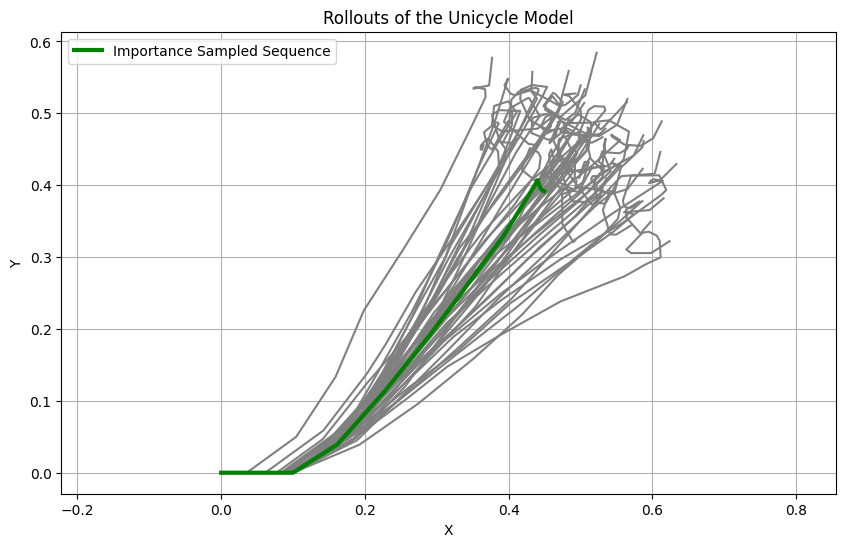

In [78]:
# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)
obs, _ = env.reset()

# Set the starting state (x, y, theta) and goal position (x, y).
initial_state = np.array([0.0, 0.0, 0.0])
goal_pos = np.array([0.5, 0.5])

# Instantiate your contoller class
controller = MPPI()

# Run your control algorithm for 1 step. We'll worry about running your
# algorithm in closed-loop in later parts of the assignment.
action = controller.get_action(initial_state, goal_pos)

## 1b) MPPI to drive around a racetrack

Now you will extend your MPPI implementation so that your robot drives around a racetrack. There are a few interesting challenges you'll need to figure out that didn't appear in the earlier problem:

*   How to score rollouts? Some possible ideas include placing waypoints around the track, designing a cost-to-go function, or encouraging the vehicle to maintain full speed, but this is completely up to you!
*   How to ensure the robot doesn't collide with the walls? You can transform coordinates from the world frame to map cell indices using `self.static_map.world_coordinates_to_map_indices(states_in_world)` and `self.static_map.static_map[map_indices]` to check whether a cell of the map is occupied or free.

**Deliverables**:
- Implement the `MPPIRacetrack` class below to enable your robot to complete a full lap around the track
- Generate a plot of the path taken with some indication of time (e.g., using a colorbar, timestamps every so often along the path, or another creative way you come up with)

In [79]:
# Create an instance of the mobile robot simulator we'll use this semester
env = gymnasium.make("gym_neu_racing/NEURacing-v0")

# Tell the simulator to directly provide the current state vector (no sensors yet)
env = StateFeedbackWrapper(env)

In [80]:
class MPPIRacetrack:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
    ):
        """ Your implementation here """
        self.motion_model = motion_model
        self.static_map = static_map
        self.motion_model = motion_model

        self.v_max = 1.0        # Linear Velocity max
        self.w_min = -2*np.pi
        self.w_max = 2*np.pi
        self.H = 10              # Horizon Length
        self.dt = 0.1           # Time Steps
        self.N = 50             # Number of Rollouts
        self.w_sig = 1.045        # Deviation for Noise
        self.v_sig = 0.001
        self.lmda = 0.1

        # raise NotImplementedError

    def get_angular_cost(self, val, end=18):
        if val<=end:
            return 0.5 + (0.8 - 0.5) * np.exp(-2 * val / end)
        else:
            return 0.5 + 0.1 * (val - end)
    
    # Cost Function
    def cost_function(self, initial_state, control_sequence):
        collision_weight, velocity_weight, smoothness_weight = [100, -0.02, 1.0]
        x, y, theta = initial_state
        cost = 0

        velocities = control_sequence[:, 0]
        angular_velocities = control_sequence[:, 1]
        
        for v, w in control_sequence:
            x += v * np.cos(theta) * self.dt
            y += v * np.sin(theta) * self.dt
            theta += w * self.dt
            current_state = np.array([x, y])
            map_indices = self.static_map.world_coordinates_to_map_indices(current_state)
            occupancy = self.static_map.static_map[map_indices[0][0], map_indices[0][1]]  
            if occupancy:
                cost += collision_weight

        # Maximize linear velocity
        cost += velocity_weight * np.sum(velocities)
        cost += self.get_angular_cost(np.sum(np.abs(np.diff(angular_velocities))))
        # print(f'{velocity_weight * np.sum(velocities)} && {self.get_angular_cost(np.sum(np.abs(np.diff(angular_velocities))))}')
        return cost
    
    def update_control(self, nominal_seq, rollouts, weights):
        du = rollouts - nominal_seq
        seq = np.zeros_like(nominal_seq)
       
        for col in range(len(nominal_seq)):
            seq[col] = np.sum(weights[:, None] * du[:, col], axis=0) / np.sum(weights)

        final_seq = nominal_seq + seq
        final_seq[:, 0] = np.clip(final_seq[:, 0], 0, 1.0)  # Clip v between 0 and 1.0
        final_seq[:, 1] = np.clip(final_seq[:, 1], -2 * np.pi, 2 * np.pi)  # Clip w between -2π and 2π

        return final_seq

    def get_action(self, initial_state: np.array) -> np.array:
        """ Your implementation here """
        
        nominal_seq = [[1.0, -1.0/3.0] for _ in range(self.H)]
        rollouts = np.array([[[np.clip(v + np.random.normal(0, self.v_sig), 0, self.v_max),  np.clip(w + np.random.normal(0, self.w_sig), -2 * np.pi, 2 * np.pi)] 
                                for v, w in nominal_seq] 
                            for _ in range(self.N)])
        scores = np.array([self.cost_function(initial_state, seq) for seq in rollouts])
        weights = np.exp(-1 * scores / self.lmda)
        ctrl_seq = self.update_control(nominal_seq, rollouts, weights)
        action = np.array([0.1, np.radians(5)/self.dt])
        action = np.array(ctrl_seq[0])
        # raise NotImplementedError
        return action

lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


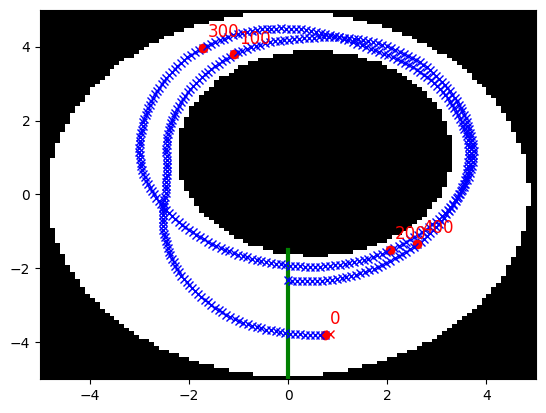

num timesteps used: 429


In [128]:
def run_planner_on_racetrack(
    env: gymnasium.Env,
    planner_class=MPPIRacetrack,
    seed: int = 0,
    num_laps: int = 3,
) -> int:

    np.random.seed(seed)
    obs, _ = env.reset()
    env.unwrapped.laps_left = num_laps

    # Create an instance of your planner
    planner = planner_class(static_map=env.unwrapped.map)

    # Draw a map of the environment with the finish line + initial position
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        env.unwrapped.finish_line[:, 0],
        env.unwrapped.finish_line[:, 1],
        "g",
        lw=3,
    )
    ax.plot(obs[0], obs[1], "rx")

    # Run the environment for num_timesteps, unless the robot hits an obstacle
    # or successfully completes the number of laps needed
    num_timesteps = 500
    success = False
    for t in range(num_timesteps):
        action = planner.get_action(obs)
        obs, _, terminated, _, _ = env.step(action)

        ax.plot(obs[0], obs[1], "bx")

        if t%100 == 0:
            ax.plot(obs[0], obs[1], "ro", label=f"{t}")
            ax.text(obs[0] + 0.1, obs[1] + 0.3, f"{t}", fontsize=12, color="red")

        if terminated:
            success = True
            break

    num_timesteps_used = t

    plt.show()

    if success:
        return num_timesteps_used
    else:
        return -1


seed = 0
num_laps = 3
planner_class = MPPIRacetrack
num_timesteps_used = run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)
print(f"num timesteps used: {num_timesteps_used}")

## [Extra Credit] 1c) Compete for the fastest lap time

In this part, you can earn extra credit by achieving faster lap times (measured in average number of steps to complete the course, not computational runtime). You can get some extra credit by implementing a working version of something interesting here (e.g., another planning algorithm, a learning-based method, an extension beyond the basic MPPI we discussed in class). We will give additional extra credit to the student with the fastest lap time, which can be monitored on the Gradescope leaderboard.

In [82]:
from scipy.optimize import fsolve

In [177]:
class BetterPlanner:
    def __init__(
        self,
        static_map,
        motion_model=motion_models.Unicycle(),
    ):
        """ Your implementation here """
        self.motion_model = motion_model
        self.static_map = static_map
        self.motion_model = motion_model

        self.v_max = 1.0        # Linear Velocity max
        self.w_min = -2*np.pi
        self.w_max = 2*np.pi
        self.dt = 0.1           # Time Steps
        self.v_sig = 0

        self.H = 10           # Horizon Length
        self.N = 100            # Number of Rollouts
        self.w_sig = 1.047      # Deviation for Noise
        self.lmda = 0.1
        self.counter = 0

        self.xg = -0.5
        self.yg = -2.0

        # raise NotImplementedError

    def get_angular_cost(self, value, end=18):
        if value<=end:
            return 0.5 + (0.8 - 0.5) * np.exp(-2 * value / end)
        else:
            return 0.5 + 0.1 * (value - end)
        
        
    def get_elipse_cost(self, x, y):
        cx, cy = 0.5, 1.0
        a = 5.0 / 2  # Semi-major axis
        b = 5.0 / 2  # Semi-minor axis
        
        # Normalize the point coordinates to ellipse frame
        norm_x = (x - cx) / a
        norm_y = (y - cy) / b

        ellipse_value = norm_x**2 + norm_y**2

        if ellipse_value < 1:
            return 10 + 100 * (1 - ellipse_value) 
        elif ellipse_value == 1:
            return 0
        else:
            return 10*(ellipse_value - 1) ** 2
        
    # Cost Function
    def cost_function(self, initial_state, control_sequence):
        collision_weight, velocity_weight, smoothness_weight = [100, -0.4/self.H, 1.0]
        x, y, theta = initial_state
        cost = 0
        velocities = control_sequence[:, 0]
        angular_velocities = control_sequence[:, 1]
        
        for v, w in control_sequence:
            x += v * np.cos(theta) * self.dt
            y += v * np.sin(theta) * self.dt
            theta += w * self.dt
            current_state = np.array([x, y])
            map_indices = self.static_map.world_coordinates_to_map_indices(current_state)
            occupancy = self.static_map.static_map[map_indices[0][0], map_indices[0][1]]  
            if occupancy:
                cost += collision_weight

        # Maximize linear velocity
        cost += velocity_weight * np.sum(velocities)
        cost += self.get_angular_cost(np.sum(np.abs(np.diff(angular_velocities))))
        cost += self.get_elipse_cost(x, y)
        # print(f'{velocity_weight * np.sum(velocities)} && {self.get_angular_cost(np.sum(np.abs(np.diff(angular_velocities))))}')
        return cost
    
    def update_control(self, nominal_seq, rollouts, weights):
        du = rollouts - nominal_seq
        seq = np.zeros_like(nominal_seq)
       
        for col in range(len(nominal_seq)):
            seq[col] = np.sum(weights[:, None] * du[:, col], axis=0) / np.sum(weights)

        final_seq = nominal_seq + seq
        final_seq[:, 0] = np.clip(final_seq[:, 0], 0, 1.0)  # Clip v between 0 and 1.0
        final_seq[:, 1] = np.clip(final_seq[:, 1], -2 * np.pi, 2 * np.pi)  # Clip w between -2π and 2π

        return final_seq
    
    def get_mppi(self, initial_state):
        w = np.random.uniform(-0.65, -0.25)
        w = np.clip(w, -2 * np.pi, 2 * np.pi)
        nominal_seq = [[self.v_max, -1.0/3.0] for _ in range(self.H)]
        rollouts = np.array([[[np.clip(v + np.random.normal(0, self.v_sig), 0, self.v_max),  np.clip(w + np.random.normal(0, self.w_sig), -2 * np.pi, 2 * np.pi)] 
                                for v, w in nominal_seq] 
                            for _ in range(self.N)])
        scores = np.array([self.cost_function(initial_state, seq) for seq in rollouts])
        weights = np.exp(-1 * scores / self.lmda)
        ctrl_seq = self.update_control(nominal_seq, rollouts, weights)
        action = np.array(ctrl_seq[0])

        return action
    
    def get_tangent(self, initial_state):
        h, k = 0.5, 1.0
        x0, y0, theta = initial_state
        x0_shifted, y0_shifted = x0 - h, y0 - k
        a = 5.25 / 2 
        b = 5.5 / 2

        def equations(vars):
            x1, y1 = vars
            eq1 = (x1 * x0_shifted) / a**2 + (y1 * y0_shifted) / b**2 - 1  # Tangent condition
            eq2 = (x1**2) / a**2 + (y1**2) / b**2 - 1                      # Ellipse equation
            return [eq1, eq2]

        theta_guess = np.arctan2(y0_shifted * a**2, x0_shifted * b**2)
        x1_guess = a * np.cos(theta_guess)
        y1_guess = b * np.sin(theta_guess)

        x1, y1 = fsolve(equations, (x1_guess, y1_guess))
        if x1 > 0:
            tc = np.array([-0.5, -2.0])
        else:
            tc = np.array([x1 + h, y1 + k])

        return tc
    
    # Function to get linear path
    def get_lp(self, initial_state, xg, yg):
        x, y, theta = initial_state
        tg = np.arctan2(yg - y, xg - x)
        dtheta = tg - theta
        dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))

        if abs(dtheta) > np.radians(90):
            w = (dtheta/np.abs(dtheta)) * 2 * np.pi
            v = 0
        else:
            w = dtheta/self.dt
            w = np.clip(w, -2 * np.pi, 2 * np.pi)
            v = self.v_max

        ellipse_value = (2*(x - 0.5)/5.0)**2 + (2*(y - 1.0)/5.0)**2

        if x < xg and y > yg:
            self.counter += 1
        elif ellipse_value<1.3:
            self.counter += 1

        return np.array([v, w])


    def get_action(self, initial_state: np.array) -> np.array:
        """ Your implementation here """
        if self.counter == 0:
            self.xg, self.yg = self.get_tangent(initial_state)
            action = self.get_lp(initial_state, self.xg, self.yg)
            self.counter += 1
        elif self.counter == 1:
            action = self.get_lp(initial_state, self.xg, self.yg)
        else:
            action = self.get_mppi(initial_state)
        # raise NotImplementedError
        return action

lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed
lap completed!
clockwise -> fwd lap completed


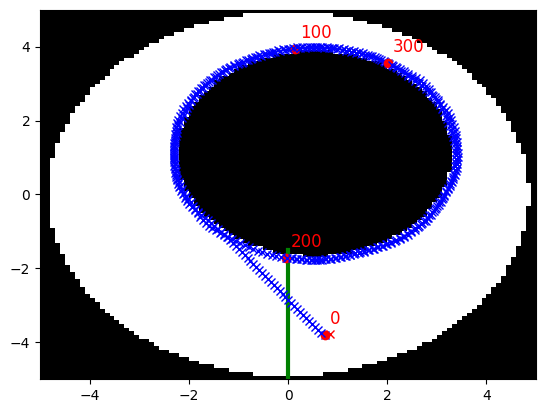

380

In [178]:
# for i in range(20):
seed = 0
num_laps = 3
planner_class = BetterPlanner
run_planner_on_racetrack(
    env, planner_class=planner_class, seed=seed, num_laps=num_laps
)


# Problem 2: Trajectory Optimization with `cvxpy`

## 2a) Double Integrator: Initial & Terminal Conditions

For this problem, you'll use the 2D discrete-time double integrator dynamics, where $$\mathbf{x}[t] = \begin{bmatrix}
x[t]\\
y[t]\\
v_x[t]\\
v_y[t]\\
\end{bmatrix}, \quad \mathbf{u}[t] = \begin{bmatrix} a_x[t]\\ a_y[t]\\ \end{bmatrix}, \quad \mathbf{x}[t+dt] = A \mathbf{x}[t] +  B \mathbf{u}[t], \quad A = \begin{bmatrix}
1 & 0 & dt & 0 \\
0 & 1 & 0 & dt \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}, \quad B = \begin{bmatrix}
\frac{dt^2}{2} & 0 \\
0 & \frac{dt^2}{2} \\
dt & 0 \\
0 & dt \\
\end{bmatrix}.
$$

You should turn the following optimization problem into code:

$$
\begin{align}
\min_{x_{0:T}, u_{0:T}}\quad & (x[T] - g_x)^2 + (y[T] - g_y)^2 \\
\text{s.t.}\quad & \mathbf{x}[t+1] = A \mathbf{x}[t] + B \mathbf{u}[t] \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{u}[t] \in U \quad \forall t \in \{0, 1, \ldots, T-1\} \\
& \mathbf{x}[0] = \mathbf{x}_0 \\
& v_x[T] = v_{x,T} \\
& v_x[T] = v_{y,T} \\
\end{align}
$$

with $g_x = 3, g_y=5, v_{x,T}=0, v_{y,T}=0, \mathbf{x}_0 = [1, 2, 0, 0], U = [-1, 1] \times [-1, 1], T=10$.

**Deliverables**:
- Implement `optimize_trajectory`, which will take in initial and terminal conditions, control limits, dt, and return the optimal sequence of states (i.e., an array of shape (T+1, 4) -- T+1 timesteps (T timesteps + the initial state) and 4 states per timestep)
- Generate a plot of your optimal trajectory. You are welcome to use the `plot_trajectory` function or write your own version.

In [85]:
def optimize_trajectory(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
) -> np.ndarray:
    """ Your implementation here"""
    T = 10  
    x = cp.Variable((4, T + 1))
    u = cp.Variable((2, T))

    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    
    B = np.array([[dt**2/2, 0],
                  [0, dt**2/2],
                  [dt, 0],
                  [0, dt]])
    
    # Initial and Final states
    constraints = [
        x[:, 0] == np.hstack((initial_pos, initial_vel)),
        x[2:, T] == goal_vel
    ]

    # Control constraints and system dynamics
    for t in range(T):
        constraints += [
            x[:, t + 1] == A @ x[:, t] + B @ u[:, t],
            u[:, t] >= u_limits[:, 0], 
            u[:, t] <= u_limits[:, 1]
        ]

    objective = cp.Minimize(cp.sum_squares(x[0:2, T] - goal_pos))

    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.OSQP)
    
    return x.value.T


def plot_trajectory(xt: np.ndarray) -> None:

    # Feel free to add to this

    plt.plot(xt[:, 0], xt[:, 1], "-x")
    plt.axis("equal")
    plt.show()

You can check whether your code works using

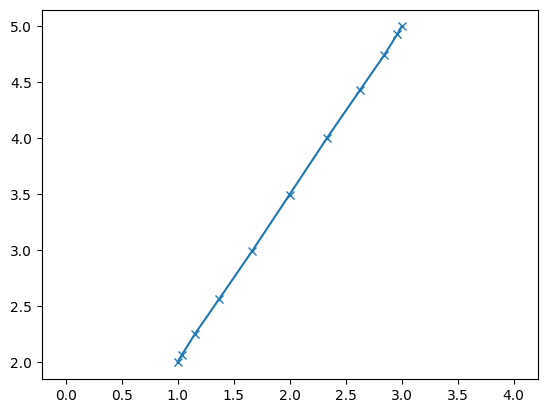

In [86]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0

optimal_xt = optimize_trajectory(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
)

plot_trajectory(np.array(optimal_xt))

## [Extra Credit] 2b) Incorporate obstacle avoidance as a convex optimization problem

Now, you should extend your optimization code to handle a list of circular obstacles that the double integrator must avoid. We would like you to try to keep this as a convex optimization problem. If you just start adding constraints and costs, you will likely end up with a non-convex optimization problem, which are generally hard to solve.

One possible way to keep the problem convex could be to break the free (i.e., non-obstacle) space into a set of convex regions, then split the trajectory into multiple segments (each one needing to stay within one convex region). But, there could be many other ways, and you are encouraged to try different strategies!


In [117]:
# A* Algorithm
import heapq

# Function to generate a grid map with obstacles
def generate_grid(grid_size=6, cell_size=0.1, obstacles=[]):
    num_cells = int(grid_size / cell_size)
    grid = np.zeros((num_cells, num_cells), dtype=int)
    for i in range(num_cells):
        for j in range(num_cells):
            x = i * cell_size + (cell_size / 2)
            y = j * cell_size + (cell_size / 2) 
            for obs_x, obs_y, radius in obstacles:
                distance = np.sqrt((x - obs_x) ** 2 + (y - obs_y) ** 2)
                if distance <= radius:
                    grid[i, j] = 1
    
    return grid

# Node Class
class Node:
    def __init__(self, position, parent=None):
        self.position = position
        self.parent = parent
        self.g = 0  # Cost from start node
        self.h = 0  # Heuristic cost to goal
        self.f = 0  # Total cost

    def __lt__(self, other):
        return self.f < other.f 
    
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def astar(grid, start, goal):
    open_list = []
    closed_set = set()
    start_node = Node(start)
    goal_node = Node(goal)
    
    heapq.heappush(open_list, start_node)

    while open_list:
        current_node = heapq.heappop(open_list)

        if current_node.position == goal_node.position:
            path = []
            while current_node:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]
        
        closed_set.add(current_node.position)

        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            neighbor_pos = (current_node.position[0] + dx, current_node.position[1] + dy)
            
            if 0 <= neighbor_pos[0] < len(grid) and 0 <= neighbor_pos[1] < len(grid[0]) and grid[neighbor_pos[0]][neighbor_pos[1]] == 0:
                if neighbor_pos in closed_set:
                    continue

                neighbor = Node(neighbor_pos, current_node)
                neighbor.g = current_node.g + 1
                neighbor.h = heuristic(neighbor_pos, goal_node.position)
                neighbor.f = neighbor.g + neighbor.h

                if not any(n.position == neighbor.position and n.f <= neighbor.f for n in open_list):
                    heapq.heappush(open_list, neighbor)

    return None

# Function to get waypoints using A* Algorithm
def get_waypoints(initial_pos, goal_pos, cell_size=0.2, obstacles=[]):
    grid = generate_grid(grid_size=6, cell_size=cell_size, obstacles=obstacles)
    start =(round(initial_pos[0]/cell_size), round(initial_pos[1]/cell_size))
    goal = (round(goal_pos[0]/cell_size), round(goal_pos[1]/cell_size))

    path = astar(grid, start, goal)
    scaled_path = [(x * cell_size, y * cell_size) for x, y in path]
    return scaled_path


# Function to remove redundant waypoint from the A* Optimized path
def simplify_waypoints(waypoints):
    slopes = []
    simplified_waypoints = [waypoints[0]]

    for i in range(len(waypoints) - 1):
        x1, y1 = waypoints[i]
        x2, y2 = waypoints[i + 1]
        slope = None if x2 - x1 == 0 else (y2 - y1) / (x2 - x1)
        slopes.append(slope)

    prev_slope = slopes[0]
    for i in range(1, len(slopes)):
        if slopes[i] != prev_slope: 
            simplified_waypoints.append(waypoints[i])
        prev_slope = slopes[i]

    simplified_waypoints.append(waypoints[-1])

    # Remove redundant points
    final_waypoints = [simplified_waypoints[0]]

    for i in range(1, len(simplified_waypoints) - 1):
        x_prev, y_prev = simplified_waypoints[i - 1]
        x_curr, y_curr = simplified_waypoints[i]
        x_next, y_next = simplified_waypoints[i + 1]

        slope_prev = (y_curr - y_prev) / (x_curr - x_prev) if x_curr - x_prev != 0 else None
        slope_next = (y_next - y_curr) / (x_next - x_curr) if x_next - x_curr != 0 else None

        if not (slope_prev == 0 and slope_next is None):
            final_waypoints.append(simplified_waypoints[i])

    final_waypoints.append(simplified_waypoints[-1])

    return final_waypoints



In [129]:
def optimize_trajectory_with_obstacles(
    initial_pos: np.ndarray,
    initial_vel: np.ndarray,
    goal_pos: np.ndarray,
    goal_vel: np.ndarray,
    u_limits: np.ndarray,
    dt: float,
    obstacles: list,
) -> np.ndarray:

    """ Your implementation here"""
    T = 100
    path = get_waypoints(initial_pos, goal_pos, cell_size=0.2, obstacles=obstacles)
    waypoints = simplify_waypoints(path)
    num_waypoints = len(waypoints)
    waypoint_indices = np.linspace(0, T, num_waypoints + 2, dtype=int)[1:-1]  # Evenly distribute waypoints

    x = cp.Variable((4, T + 1))
    u = cp.Variable((2, T))

    A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    
    B = np.array([[dt**2/2, 0],
                  [0, dt**2/2],
                  [dt, 0],
                  [0, dt]])
    
    # Constraints List
    constraints = [x[:, 0] == np.hstack((initial_pos, initial_vel))]

    # Control limits and system dynamics constraints
    for t in range(T):
        constraints += [
            x[:, t + 1] == A @ x[:, t] + B @ u[:, t],
            u[:, t] >= u_limits[:, 0],  
            u[:, t] <= u_limits[:, 1]   
        ]

    for t_wp, pos_wp in zip(waypoint_indices, waypoints):
        constraints += [
            x[0:2, t_wp] == pos_wp # Waypoint constraint
        ]

    constraints += [
        x[0:2, T] == goal_pos,  # Final position constraint
        x[2:4, T] == goal_vel   # Final velocity constraint
    ]

    # Objective function
    objective = cp.Minimize(
        0.1 * cp.sum_squares(u[:, :-1] - u[:, 1:]) +
        10 * cp.sum_squares(x[0:2, T] - goal_pos) +
        0.1 * cp.sum_squares(u)
    )

    # Solve optimization problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS) 

    if problem.status != cp.OPTIMAL:
        raise ValueError("Optimization failed!")

    return x.value.T, waypoints


def plot_trajectory_with_obstacles(
    xt: np.ndarray,
    obstacles: list[np.ndarray],
    final_waypoints: np.ndarray,
) -> None:

    # Feel free to add to this
    fig, ax = plt.subplots()

    x_coords, y_coords = zip(*final_waypoints)
    plt.scatter(x_coords, y_coords, color='green', marker='o', s=50, label="Waypoints")

    plt.plot(xt[:, 0], xt[:, 1], "-x")
    for obstacle in obstacles:
        ax.add_patch(plt.Circle(obstacle[0:2], obstacle[2], color="r"))
    
    # path_x = [x for x, _ in path]
    # path_y = [y for _, y in path]
    # plt.plot(path_x, path_y, marker="o", color="green", markersize=1, label="Path")
    
    plt.axis("equal")
    plt.show()

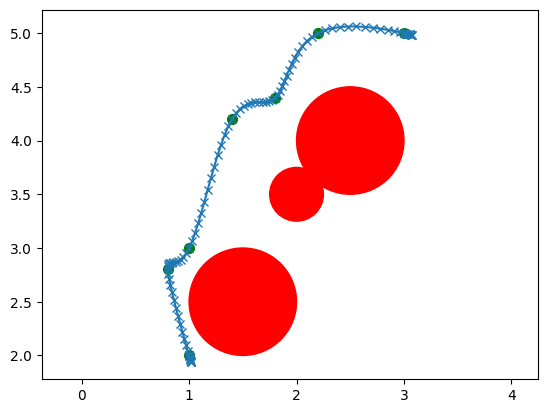

In [130]:
initial_pos = np.array([1.0, 2.0])
initial_vel = np.array([0.0, 0.0])
goal_pos = np.array([3.0, 5.0])
goal_vel = np.array([0.0, 0.0])
u_limits = 0.2 * np.array([[-1.0, 1.0], [-1.0, 1.0]])
dt = 1.0 

obstacles = [
    (1.5, 2.5, 0.5),
    (2.0, 3.5, 0.25),
    (2.5, 4.0, 0.5),
]

optimal_xt, final_waypoints = optimize_trajectory_with_obstacles(
    initial_pos,
    initial_vel,
    goal_pos,
    goal_vel,
    u_limits,
    dt,
    obstacles,
)

plot_trajectory_with_obstacles(optimal_xt, obstacles, final_waypoints)